In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached typing-3.7.4.3-py3-none-any.whl
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=1073 sha256=b125839fccc41947614acd0fb477a4cd383c45dfc4c4d3f62424b7ba0fe2f36b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgqspq54/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install gym
%pip install optuna
%pip install rl_zoo3

In [1]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_density, geom_line, geom_point, geom_violin, facet_grid, labs, theme, facet_wrap

from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import simulator
import gym

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history, plot_param_importances
import gymnasium as gym
import logging
import numpy as np

from gymnasium import spaces
from scipy.stats import norm

import sample_params

In [2]:
logging.basicConfig(filename="/home/rstudio/rl4greencrab/notebooks/env_log.txt",format='%(levelname)s: %(message)s', level=logging.DEBUG)

class greenCrabEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        config=None,
    ):
        # if config == {}:
        #     config = {
        #         "Tmax": 100,
        #         "growth_k": 0.43, "growth_xinf": 109, "growth_sd": 2.5, "nmortality": 0.03,
        #         "trapm_sigma": 0.15, "trapm_xmax": 44, "trapm_pmax": 0.0005, "trapf_pmax": 0.0008,
        #         "trapf_k": 0.5, "trapf_midpoint": 45, "init_mean_recruit": 15, "init_sd_recruit": 1.5,
        #         "init_mean_adult": 65, "init_sd_adult": 8, "init_n_recruit": 1000, "init_n_adult": 1000,
        #         "w_mort_scale": 5, "K": 25000, "imm": 10, "r": 50, "area": 4000,"loss_a": 0.265,
        #         "loss_b": 2.80, "loss_c": 2.99, "minsize": 5, "maxsize": 110, "nsize": 21, "ntime":9,"delta_t": 1/12,
        #         "env_stoch": 0.1, "action_reward_scale":0.001
        #     }
        
        config=config or {}
        
        # parameters
        self.growth_k = np.float32(config.get("growth_k", 0.43))
        self.growth_xinf = np.float32(config.get("growth_xinf", 109))
        self.growth_sd = np.float32(config.get("growth_sd", 2.5))
        self.nmortality = np.float32(config.get("nmortality", 0.03))
        
        self.trapm_sigma = np.float32(config.get("trapm_sigma", 6))
        self.trapm_xmax = np.float32(config.get("trapm_xmax", 47))
        self.trapm_pmax = np.float32(config.get("trapm_pmax", 2.26e-6))
        #
        self.trapf_pmax = np.float32(config.get("trapf_pmax", 8.3e-7))
        self.trapf_k = np.float32(config.get("trapf_k", 0.4))
        self.trapf_midpoint = np.float32(config.get("trapf_midpoint", 41))
        #
        self.traps_pmax = np.float32(config.get("traps_pmax", 2.75e-5))
        self.traps_k = np.float32(config.get("traps_k", 0.4))
        self.traps_midpoint = np.float32(config.get("traps_midpoint", 45))
        
        self.init_mean_recruit = config.get("init_mean_recruit", 15)
        self.init_sd_recruit = config.get("init_sd_recruit", 1.5)
        self.init_mean_adult = config.get("init_mean_adult", 65)
        self.init_sd_adult = config.get("init_sd_adult", 8)
        self.init_n_recruit = config.get("init_n_recruit", 0)
        self.init_n_adult = config.get("init_n_adult", 0)
        
        self.w_mort_scale = config.get("w_mort_scale", 5)
        self.K = config.get("K", 25000) #carrying capacity
        self.imm = config.get("imm", 1000) #colonization/immigration rate
        self.r = config.get("r", 1) #intrinsic rate of growth

        self.max_action = config.get("max_action", 2000)
        self.max_obs = config.get("max_obs", 2000)
        
        self.area = config.get("area", 4000)
        self.loss_a = config.get("loss_a", 0.265)
        self.loss_b = config.get("loss_b", 2.80)
        self.loss_c = config.get("loss_c", 2.99)
        
        self.minsize = config.get("minsize", 5)
        self.maxsize = config.get("maxsize", 110)
        self.nsize = config.get("nsize", 21)
        self.ntime = config.get("ntime", 9)
        
        self.delta_t = config.get("delta_t", 1/12)
        self.env_stoch = config.get("env_stoch", 0.1)
        
        self.action_reward_scale = np.array(config.get("action_reward_scale", [0.1, 0.1, 10]))
        self.action_reward_exponent = config.get("action_reward_exponent", 1)
        
        self.config = config

        # Preserve these for reset
        self.observations = np.zeros(shape=9, dtype=np.float32)
        self.reward = 0
        self.years_passed = 0
        self.Tmax = config.get("Tmax", 100)
                
        # Initial variables
        self.bndry = self.boundary()
        self.state = self.init_state()
        self.midpts = self.midpoints()
        self.gm_ker = self.g_m_kernel()
        self.w_mort = self.w_mortality()
        self.w_mort_exp = np.exp(-self.w_mort)
        self.pmort = np.exp(-self.nmortality)

        # Action space
        # action -- # traps per month
        self.action_space = spaces.Box(
            np.array([0, 0, 0], dtype=np.float32),
            np.array(3*[self.max_action], dtype=np.float32),
            dtype=np.float32,
        )
        
        # Observation space
        self.observation_space = spaces.Box(
            np.zeros(shape=self.ntime, dtype=np.float32),
            self.max_obs * np.ones(shape=self.ntime, dtype=np.float32),
            dtype=np.float32,
        )
        
    def step(self, action):
        # Size selective harvest rate, given action
        harvest_rate = (
            1 - np.exp(-(
                self.size_sel_norm() * action[0] +
                self.size_sel_log(self.trapf_pmax, self.trapf_midpoint, self.trapf_k) * action[1] +
                self.size_sel_log(self.traps_pmax, self.traps_midpoint, self.traps_k) * action[2]
            ))
        )
        
        # Add population at t=1
        size_freq = np.zeros(shape=(self.nsize, self.ntime), dtype='object')
        size_freq[:, 0] = self.state
        
        # Create array to store # removed
        removed = np.zeros(shape=(self.nsize, self.ntime), dtype='object')
        
        # Calculate removed and record observation at t=1
        removed[:, 0] = [np.random.binomial(size_freq[k, 0], harvest_rate[k]) for k in range(self.nsize)]
        self.observations[0] = np.sum(removed[:, 0])
        
        # Loop through intra-annual change (9 total months), t=2+
        for j in range(self.ntime - 1):
            n_j = self.gm_ker @ (size_freq[:, j] - removed[:, j])
            size_freq[:, j+1] = [np.random.binomial(n=n_j[k], p=self.pmort) for k in range(self.nsize)]
            removed[:, j+1] = [np.random.binomial(size_freq[k, j+1], harvest_rate[k]) for k in range(self.nsize)]
        
        # Record the catch in the observation space
        self.observations = np.array([np.sum(removed[:, j]) for j in range(self.ntime)], dtype=np.float32)
        
        # Calculate new adult population after overwinter mortality
        new_adults = [np.random.binomial(size_freq[k, 8], self.w_mort_exp[k]) for k in range(self.nsize)]
        
        # Simulate new recruits
        local_recruits = np.random.normal(self.dd_growth(size_freq[:, self.ntime-1]), self.env_stoch)
        nonlocal_recruits = np.random.poisson(self.imm) * (1 - np.sum(size_freq[:, self.ntime-1]) / self.K)
        recruit_total = local_recruits + nonlocal_recruits
        
        # Get sizes of recruits
        recruit_sizes = (norm.cdf(self.bndry[1:(self.nsize+1)], self.init_mean_recruit, self.init_sd_recruit) -
                         norm.cdf(self.bndry[0:self.nsize], self.init_mean_recruit, self.init_sd_recruit)) * recruit_total
        
        # Store new population size (and cap off at zero pop)
        self.state = np.maximum(recruit_sizes + new_adults, 0)
        
        # Calculate reward
        self.reward = self.reward_func(action)
        self.years_passed += 1
        
        done = bool(self.years_passed > self.Tmax)
        
        return self.observations, self.reward, done, done, {}


        
    def reset(self, *, seed=42, options=None):
        self.state = self.init_state()
        self.years_passed = 0

        # for tracking only
        self.reward = 0

        self.observations = np.zeros(shape=self.ntime, dtype=np.float32)

        return self.observations, {}

    #################
    #helper functions

    #set up boundary points of IPM mesh
    def boundary(self):
        boundary = self.minsize+np.arange(0,(self.nsize+1),1)*(self.maxsize-self.minsize)/self.nsize
        return boundary

    #set up mid points of IPM mesh
    def midpoints(self):
        midpoints = 0.5*(self.bndry[0:self.nsize]+self.bndry[1:(self.nsize+1)])
        return midpoints

    #function for initial state
    def init_state(self):
        init_pop = (norm.cdf(self.bndry[1:(self.nsize+1)],self.init_mean_adult,self.init_sd_adult)-\
         norm.cdf(self.bndry[0:self.nsize],self.init_mean_adult,self.init_sd_adult))*self.init_n_adult+\
        (norm.cdf(self.bndry[1:(self.nsize+1)],self.init_mean_recruit,self.init_sd_recruit)-\
         norm.cdf(self.bndry[0:self.nsize],self.init_mean_recruit,self.init_sd_recruit))*self.init_n_recruit
        return init_pop

    #function for logistic size selectivity curve
    def size_sel_log(self, trap_pmax, trap_midpts, trap_k):
        size_sel = trap_pmax/(1+np.exp(-trap_k*(self.midpts-trap_midpts)))
        return size_sel

    #function for gaussian size selectivity curve
    def size_sel_norm(self):
        size_sel = self.trapm_pmax*np.exp(-(self.midpts-self.trapm_xmax)**2/(2*self.trapm_sigma**2))
        return size_sel

    #function for growth/mortality kernel
    def g_m_kernel(self):
        array = np.empty(shape=(self.nsize,self.nsize),dtype='object')
        for i in range(self.nsize):
            mean = (self.growth_xinf-self.midpts[i])*(1-np.exp(-self.growth_k*self.delta_t)) + self.midpts[i]
            array[:,i] = (norm.cdf(self.bndry[1:(self.nsize+1)],mean,self.growth_sd)-\
                          norm.cdf(self.bndry[0:self.nsize],mean,self.growth_sd))
        return array

    #function for overwinter mortality
    def w_mortality(self):
        wmort = self.w_mort_scale/self.midpts
        return wmort

    #function for density dependent growth
    def dd_growth(self,popsize):
        dd_recruits = np.sum(popsize)*self.r*(1-np.sum(popsize)/self.K)
        return dd_recruits

    #function for reward
    # two part reward function:
    # 1. impact on environment (function of crab density)
    # 2. penalty for how much effort we expended (function of action)
    def reward_func(self,action):
        def trap_cost(action, max_action, exponent):
            return np.array(
                [
                    (action[0]/max_action) ** exponent,
                    (action[1]/max_action) ** exponent,
                    (action[2]/max_action) ** exponent,
                ]
            )
        reward = (
            -self.loss_a 
            /
            (
                1+np.exp(-self.loss_b*(np.sum(self.state)/self.area-self.loss_c))
            )
            - np.sum(
                self.action_reward_scale 
                * trap_cost(action, self.max_action, self.action_reward_exponent) 
            )
        )
        return reward


class greenCrabSimplifiedEnv(greenCrabEnv):
    """ like invasive_IPM but with simplified observations and normalized to -1, 1 space. """
    def __init__(self, config={}):
        super().__init__(config=config)
        self.observation_space = spaces.Box(
            np.array([-1,-1], dtype=np.float32),
            np.array([1,1], dtype=np.float32),
            dtype=np.float32,
        )
        self.action_space = spaces.Box(
            np.float32([-1, -1, -1]),
            np.float32([1, 1, 1]),
            dtype=np.float32,
        )
        self.max_action = config.get('max_action', 2000) # ad hoc based on previous values
        self.cpue_normalization = config.get('cpue_normalization', 100)
        
    def step(self, action):
        action_natural_units = np.maximum( self.max_action * (1 + action)/2 , 0.)
        obs, rew, term, trunc, info = super().step(
            np.float32(action_natural_units)
        )
        normalized_cpue = 2 * self.cpue_2(obs, action_natural_units) - 1
        # observation = np.float32(np.append(normalized_cpue, action))
        observation = normalized_cpue

        #sign_reward_zero = any(action == 0) * 10000  # Add a fixed penalty if any action component is 0.
        #sign_penalty_extreme = any(abs(action) == 1) * 10000
        
        rew = 10 * rew # use larger rewards, possibly makes trainer easier?

        # print(f'aciton is {action}')
        return observation, rew, term, trunc, info

    def reset(self, *, seed=42, options=None):
        _, info = super().reset(seed=seed, options=options)

        # completely new  obs
        return - np.ones(shape=self.observation_space.shape, dtype=np.float32), info

    def cpue_2(self, obs, action_natural_units):
        # If you don't set traps, the catch-per-effort is 0/0.  Should be NaN, but we call it 0
        if np.sum(action_natural_units) <= 0:
            return np.float32([0,0])
        #return np.float32([np.NaN,np.NaN])
        # can't tell which traps caught each number of crabs here. Perhaps too simple but maybe realistic 
        cpue_2 = np.float32([
            np.sum(obs[0:5]) / (self.cpue_normalization * np.sum(action_natural_units)),
            np.sum(obs[5:]) / (self.cpue_normalization * np.sum(action_natural_units))
        ])
        return cpue_2

In [3]:
config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }

In [4]:
gcse = greenCrabSimplifiedEnv(config)
vec_env = make_vec_env(greenCrabSimplifiedEnv, n_envs=12)

In [9]:
gcse.step(np.float32([0.0, 3.3306690738754696e-13, 0.0]))

(array([-1., -1.], dtype=float32), -72.43522614947211, False, False, {})

In [11]:
gcse.state

array([1.35424417e+00, 1.57679702e+03, 1.58179702e+03, 5.73542442e+01,
       1.82000000e+02, 4.10000000e+02, 5.61000000e+02, 4.95000000e+02,
       2.71000000e+02, 1.18000000e+02, 5.00000000e+01, 2.20000000e+01,
       1.00000000e+01, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [12]:
observation

array([-0.99461776, -0.9957733 ], dtype=float32)

In [13]:
reward

-999.7681232549211

In [ ]:
model = PPO("MlpPolicy", vec_env, verbose=0, 
            batch_size =  64, 
            n_steps = 32, 
            gamma = 0.9999, 
            learning_rate = 0.020439420278073966, 
            ent_coef = 7.676877009214456e-07, 
            clip_range =  0.1, 
            n_epochs = 20, 
            gae_lambda = 0.9, 
            max_grad_norm = 5, 
            vf_coef = 0.9694540149524578, 
            tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps= 500_000, 
	progress_bar=True,
)
model.save("ppo_gcse_short")

Output()

In [7]:
hyperparameter = {'gamma': 0.9999, 
                  'learning_rate': 0.020439420278073966, 
                  'batch_size': 16, 
                  'buffer_size': 10000, 
                  'learning_starts': 0, 
                  'train_freq': 16, 
                  'tau': 0.05, 
                  'log_std_init': -2.392885376919297, 
                  'net_arch': 'big', 
                  'n_quantiles': 31, 
                  'top_quantiles_to_drop_per_net': 1}

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy

In [10]:
ppoAgent = PPO.load("ppo_gcse_short")
# tunningAgent = TD3.load("tunning_best_gcse")
evalEnv = greenCrabSimplifiedEnv(config)

In [23]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.

PPO reward = -127.54202 +/- 0.50037

In [24]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000e+00,0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-9.658372e-11,0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-6.107395e-10,0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-5.530218e-09,0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-9.672240e-08,0


<Axes: xlabel='t'>

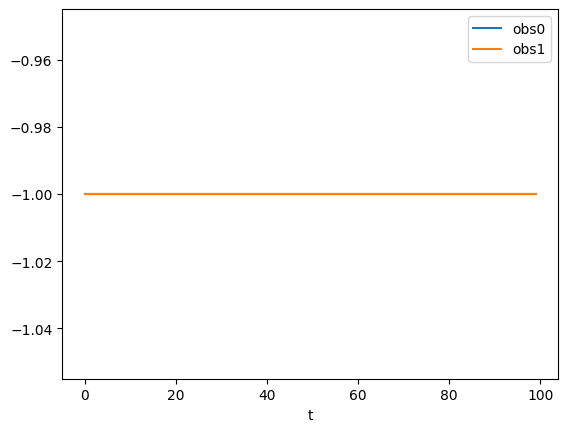

In [18]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

<Axes: xlabel='t'>

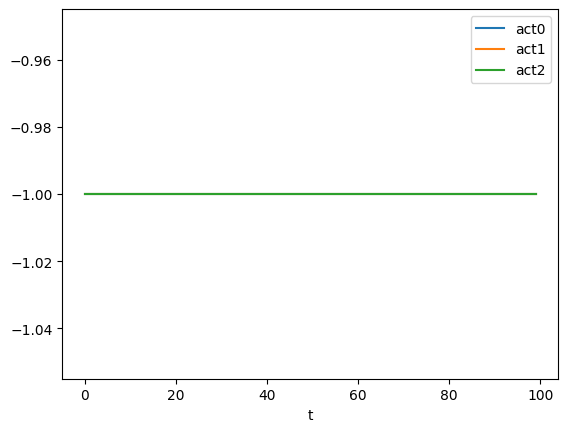

In [19]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

In [15]:
model = TQC("MlpPolicy", 
            vec_env, 
            verbose=0, 
            gamma= 0.9999, 
            learning_rate = 0.020439420278073966, 
            batch_size = 16, 
            buffer_size = 10000, 
            learning_starts= 0, 
            train_freq = 16, 
            tau = 0.05, 
            top_quantiles_to_drop_per_net = 1)
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("tqc_gcse_short")

Output()

In [8]:
tqcAgent = TQC.load("./study_results/tunning_best_gcse_tqc_config_2")
mean_rew, std_rew = evaluate_policy(tqcAgent, evalEnv)
print(f"TQC reward = {mean_rew:.5f} +/- {std_rew:.5f}")

TQC reward = -0.00470 +/- 0.00011


(   t      obs0      obs1      act0      act1      act2           rew  rep
 0  0 -1.000000 -1.000000 -0.729967 -0.564515 -0.739773  0.000000e+00    0
 1  1 -1.000000 -1.000000 -0.729967 -0.564515 -0.739773 -1.989208e-07    0
 2  2 -1.000000 -0.999475 -0.729887 -0.564445 -0.739707 -3.982536e-07    0
 3  3 -0.998426 -0.996880 -0.729298 -0.563955 -0.739245 -6.001561e-07    0
 4  4 -0.995135 -0.995163 -0.728631 -0.563427 -0.738744 -8.168965e-07    0,
 <Axes: xlabel='t'>,
 <Axes: xlabel='t'>)

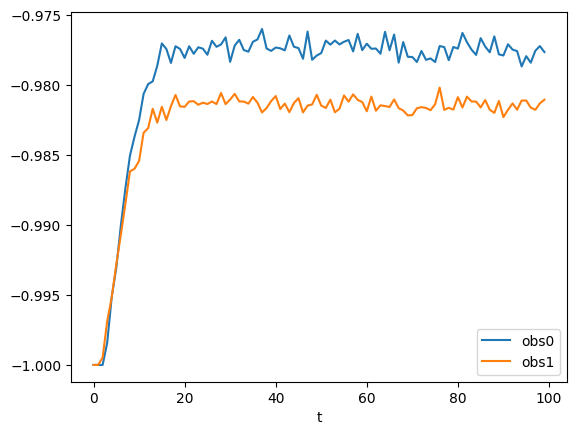

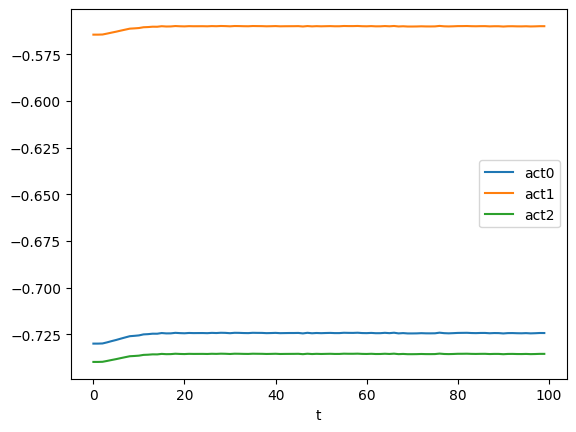

In [9]:
tqcData = simulator(env = evalEnv, agent = tqcAgent).simulate_full_named_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
(
    tqcDataDF.head(),
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['act0','act1','act2']),
)

In [5]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse_short")

Output()

In [11]:
td3Agent = TD3.load("td3_gcse_short")
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


TD3 reward = -0.00151 +/- 0.00000


(<Axes: xlabel='t'>, <Axes: xlabel='t'>)

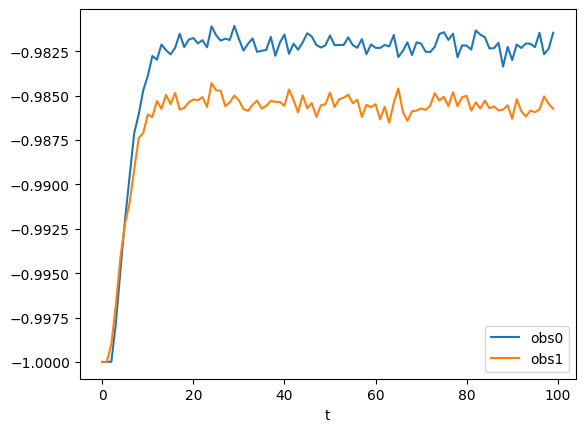

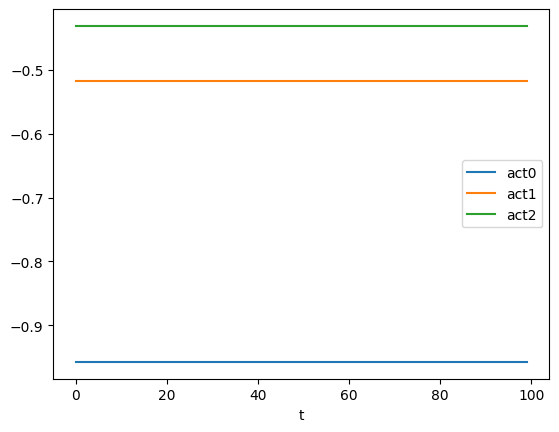

In [13]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
(
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['obs0', 'obs1']),
    td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2']),
)

## Constant Action

In [10]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)
from rl4greencrab import greenCrabEnv, greenCrabSimplifiedEnv
from rl4greencrab import simulator, constAction, multiConstAction, constActionNatUnits, evaluate_agent
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

In [11]:
def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 100,
        'loss_b': 10,
        'loss_c': 0.5,
        
        'action_reward_exponent': 10,
    }
    env = greenCrabSimplifiedEnv(config=config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    print(m_reward)
    return - m_reward

In [ ]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

In [26]:
evaluateConstAct(
    [0.0, 1222.9571833609382, 1175.8018447601435]
)
# [0.0, 3.3306690738754696e-13, 0.0]

-2.579183694045056e+30


2.579183694045056e+30

In [30]:
ep_rew = 0
for i in range(100):
    observation, reward, terminated, truncated, info = gcse.step(np.array([0.0, 3.3306690738754696e-13, 0.0]))
    ep_rew += reward

In [31]:
ep_rew

-99981.84222500451